In [1]:
!pip install pysoundfile

In [0]:
#!rm -rf RAVDESS/     # use this to clean the Data Set folder
#!rm -rf RAVDESS.zip  # use this to force re download

In [0]:
# helper to download the Data Set from Google Drive

import requests
import os

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


# Download the Data Set

Uncomment the `file_id` of the Data Set you want to use.




In [0]:
# RAVDESS_original.zip https://drive.google.com/open?id=1WyJsDuxJlUObBCFrNZLAXM2w4-sp0CxN
# file_id = '1WyJsDuxJlUObBCFrNZLAXM2w4-sp0CxN'

# RAVDESS_trimmed.zip https://drive.google.com/open?id=1pFum_YGf2C82HJvMwt0gi8apj6PJLi0s
#file_id = '1pFum_YGf2C82HJvMwt0gi8apj6PJLi0s'

# RAVDESS_enriched.zip https://drive.google.com/open?id=1LG42oQTSs6HWMLsdqhFKbADA2wi8234_
file_id = '1LG42oQTSs6HWMLsdqhFKbADA2wi8234_'

# RAVDESS_spectogram.zip https://drive.google.com/open?id=1jDb2GDnapxx-5bhRR4rudVLxd4ajrpF-
# file_id = '1jDb2GDnapxx-5bhRR4rudVLxd4ajrpF-'

destination = 'RAVDESS.zip'

if not os.path.exists(destination):
    download_file_from_google_drive(file_id, destination)

In [4]:
!ls -l

total 702916
-rw-r--r-- 1 root root 719774317 Nov 14 15:58 RAVDESS.zip
drwxr-xr-x 1 root root      4096 Nov  6 16:17 sample_data


In [5]:
!unzip -n RAVDESS.zip

Archive:  RAVDESS.zip
   creating: RAVDESS/
   creating: RAVDESS/enriched/
  inflating: RAVDESS/enriched/03-01-05-01-01-01-22-00.wav  
  inflating: RAVDESS/enriched/03-01-04-02-01-02-14-02.wav  
  inflating: RAVDESS/enriched/03-01-02-01-02-02-21-01.wav  
  inflating: RAVDESS/enriched/03-01-05-01-01-02-12-01.wav  
  inflating: RAVDESS/enriched/03-01-04-01-01-01-07-00.wav  
  inflating: RAVDESS/enriched/03-01-06-01-02-02-09-01.wav  
  inflating: RAVDESS/enriched/03-01-03-02-01-02-02-00.wav  
  inflating: RAVDESS/enriched/03-01-01-01-01-02-01-01.wav  
  inflating: RAVDESS/enriched/03-01-06-01-01-01-06-01.wav  
  inflating: RAVDESS/enriched/03-01-04-02-01-01-08-01.wav  
  inflating: RAVDESS/enriched/03-01-02-02-01-02-12-01.wav  
  inflating: RAVDESS/enriched/03-01-01-01-01-01-21-01.wav  
  inflating: RAVDESS/enriched/03-01-06-01-01-02-24-00.wav  
  inflating: RAVDESS/enriched/03-01-06-02-01-01-04-01.wav  
  inflating: RAVDESS/enriched/03-01-05-01-02-02-09-01.wav  
  inflating: RAVDESS/enri

In [6]:
!ls RAVDESS/ -l

total 380
drwxr-xr-x 2 root root 241664 Oct 15 20:05 enriched
drwxr-xr-x 2 root root  69632 Oct 15 20:43 original
drwxr-xr-x 2 root root   4096 Oct 15 19:44 spectograms
drwxr-xr-x 2 root root  69632 Oct 15 19:50 trimmed


In [7]:
!echo "Files in RAVDESS/original:" $(find RAVDESS/original/ -type f| wc -l)
!echo "Files in RAVDESS/trimmed:" $(find RAVDESS/trimmed/ -type f| wc -l)
!echo "Files in RAVDESS/enriched:" $(find RAVDESS/enriched/ -type f| wc -l)
!echo "Files in RAVDESS/spectograms:" $(find RAVDESS/spectograms/ -type f| wc -l)

Files in RAVDESS/original: 1440
Files in RAVDESS/trimmed: 1440
Files in RAVDESS/enriched: 4320
Files in RAVDESS/spectograms: 0


In [0]:
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
from scipy.signal import spectrogram
import math
import matplotlib.pyplot as plt
import random
import re
import gc
from IPython.display import Image, display
from sklearn.model_selection import train_test_split

In [0]:
random.seed(42) # set the random seed

In [0]:
# This class handles the preparation of the RAVDESS Data Set

class RAVDESS:
    
    def __init__(self, frequency):
        # store audio file name identifier mapping helpers, see the original documentation https://zenodo.org/record/1188976#.XaYUupIzaUk
        self.frequency = frequency
        self.separator = "-"
        self.audio_only = "03"
        self.voice_channel = "01"
        self.emotions = {
            "01": "neutral", 
            "02": "calm", 
            "03": "happy", 
            "04": "sad", 
            "05": "angry", 
            "06": "fearful", 
            "07": "disgust", 
            "08": "surprised"
        }
        self.emotion_intensities = {"01": "normal", "02": "strong"}
        self.statements = {"01": "Kids_are_talking_by_the_door", "02": "Dogs_are_sitting_by_the_door"}
        self.repetitions = ["01", "02"]
        self.actors = {
            "01": "male", 
            "02": "female", 
            "03": "male", 
            "04": "female", 
            "05": "male", 
            "06": "female", 
            "07": "male", 
            "08": "female", 
            "09": "male", 
            "10": "female", 
            "11": "male", 
            "12": "female", 
            "13": "male", 
            "14": "female", 
            "15": "male", 
            "16": "female", 
            "17": "male", 
            "18": "female", 
            "19": "male", 
            "20": "female", 
            "21": "male", 
            "22": "female", 
            "23": "male",
            "24": "male",
        }
        self.shown_specs = 0

        # store helper paths
        self.data_set_path = 'RAVDESS/'
        self.original_data_path = self.data_set_path + 'original/'
        self.trimmed_data_path = self.data_set_path + 'trimmed/'
        self.enriched_data_path = self.data_set_path + 'enriched/'
        self.spectograms_data_path = self.data_set_path + 'spectograms/'

        # create the directories if needed
        if not os.path.exists(self.trimmed_data_path):
          os.mkdir(self.trimmed_data_path)

        if not os.path.exists(self.enriched_data_path):
          os.mkdir(self.enriched_data_path)

        if not os.path.exists(self.spectograms_data_path):
          os.mkdir(self.spectograms_data_path)

        return

    # List all audio file paths
    def get_audio_paths_common(self, directory):
        audio_files = os.listdir(directory) # list all audio files
        audio_files = [directory + audio_file_name for audio_file_name in audio_files] # append prefix path
        return audio_files

    def get_original_audio_paths(self):
        return self.get_audio_paths_common(self.original_data_path)

    def get_trimmed_audio_paths(self):
        return self.get_audio_paths_common(self.trimmed_data_path)

    def get_enriched_audio_paths(self):
        return self.get_audio_paths_common(self.enriched_data_path)
    
    def get_spectograms_paths(self):
        return self.get_audio_paths_common(self.spectograms_data_path)

    def get_file_name_without_extension(self, file_path):
        return os.path.splitext(os.path.basename(file_path))[0]

    
    # Trim the silent data from the audio files
    def trim_audios(self):
        print('Trimming audio files - remove the silent data from the audio files')
        num_of_original_files = len(os.listdir(self.original_data_path))
        num_of_trimmed_files = len(os.listdir(self.trimmed_data_path))
        print(str(num_of_trimmed_files) + '/' + str(num_of_original_files))

        audio_paths = self.get_original_audio_paths()
        finished = 0
        for audio_path in audio_paths:
            new_trimmed_file_path = self.trimmed_data_path + os.path.basename(audio_path) # on a new path with the same file name

            # if the trimmed file doesn't exist create it
            if not os.path.exists(new_trimmed_file_path):
                audio_data, samplerate = librosa.load(audio_path, sr=self.frequency) # load and convert the audio
                audio_data_filtered, index = librosa.effects.trim(audio_data, top_db=30, frame_length=2048, hop_length=512) # trim the silent data from the audio file

                librosa.output.write_wav(new_trimmed_file_path, audio_data_filtered, samplerate) # write out the trimmed data

                finished += 1
                print(str(num_of_trimmed_files + finished) + '/' + str(num_of_original_files) + ' Trimmed: ' + audio_path) # log progress
    
    # Add noise to the audio to create more samples
    def create_audio_with_noise(self, data, number_of_noisy_audios):
        mean, std = data.mean(), data.std()
        noised_data = []

        # Add noise based on the standard deviation
        for i in range(number_of_noisy_audios):
            noise = np.random.normal(mean, std*random.uniform(0.1, 0.3), data.shape) 
            noised_data.append(data + noise)
        return noised_data

    # Save the noised audio data
    def create_save_noised_audio(self, number_of_noisy_audios):
        print('Noise audios - enrich the original ' + str(number_of_noisy_audios + 1) + ' times')

        num_of_trimmed_files = len(os.listdir(self.trimmed_data_path))
        num_of_needed_enriched_files = num_of_trimmed_files * (number_of_noisy_audios + 1)
        num_of_enriched_files = len(os.listdir(self.enriched_data_path))
        print(str(num_of_enriched_files) + '/' + str(num_of_needed_enriched_files))

        audio_paths = self.get_trimmed_audio_paths()
        finished = 0
        for audio_path in audio_paths:
            audio_data, samplerate = sf.read(audio_path) # load the audio

            new_path_base = self.enriched_data_path + self.get_file_name_without_extension(audio_path) # set directory and remove file extension from the original path
            unmodified_data_new_path = new_path_base + '-00.wav' # append a new identifier Noised data ID
            if not os.path.exists(unmodified_data_new_path):
                sf.write(unmodified_data_new_path, audio_data, samplerate) # this is the non noised trimmed audio
                finished += 1
                print(str(num_of_enriched_files + finished) + '/' + str(num_of_needed_enriched_files) + ' Enrichment: ' + unmodified_data_new_path) # log progress

            # add noise to the trimmed audio
            noised_data = self.create_audio_with_noise(audio_data, number_of_noisy_audios)

            # write out the noised audio
            for i in range(0, len(noised_data)):
                new_file_name = new_path_base + '-' + "{:02d}".format(i+1) + '.wav'
                if not os.path.exists(new_file_name):
                    sf.write(new_file_name, noised_data[i], samplerate)

                    finished += 1
                    print(str(num_of_enriched_files + finished) + '/' + str(num_of_needed_enriched_files) + ' Enrichment: ' + new_file_name) # log progress
                    
                      
    def create_spectograms(self):
        print('Create spectograms')
        num_of_enriched_files = len(os.listdir(self.enriched_data_path))
        num_of_spectograms = len(os.listdir(self.spectograms_data_path))
        print(str(num_of_spectograms) + '/' + str(num_of_enriched_files))

        audio_paths = self.get_enriched_audio_paths()
        finished = 0
        for audio_path in audio_paths:
            spectogram_path = self.spectograms_data_path + self.get_file_name_without_extension(audio_path) + '.png' # create a path with the same name and a replaced file extension
            if not os.path.exists(spectogram_path):
                audio_data, samplerate = sf.read(audio_path)
                '''window_lenght = samplerate * 1
                window_offset = math.floor(samplerate * 0.1)
                window_start = 0
                split_audio_data = audio_data[window_start : window_start + window_lenght]'''
                nfft = 128
                fig,ax = plt.subplots(1)
                fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
                fig.set_size_inches(8*len(audio_data)/samplerate,8)
                spect, f, t, image = plt.specgram(audio_data, NFFT=nfft, Fs=samplerate, noverlap=nfft/2)
                plt.axis('off')
                plt.gray() # convert the image into black-and-white
                fig.savefig(spectogram_path, dpi=300)

                finished += 1
                print(str(num_of_spectograms + finished) + '/' + str(num_of_enriched_files) + ' Created spectogram: ' + spectogram_path) # log progress

                plt.close()
                #gc.collect() # this won't solve the issue, but it will crash later... https://github.com/matplotlib/matplotlib/issues/8519
                     
    
    def name_to_data(self, spectogram_path):
        numbers = re.findall(r'\d+', spectogram_path) # numbers in the name of the audio file
        # spectogram = Image.open(spectogram_path) # consumes too much memory
        return [
            self.emotions[numbers[2]],
            self.emotion_intensities[numbers[3]],
            self.statements[numbers[4]],
            self.repetitions[int(numbers[5])-1],
            numbers[6], 
            self.actors[numbers[6]], 
            spectogram_path
        ]
        
    
    # Creates the Data Frame for the RAVDESS
    def create_dataframe(self):
        print('Create dataframe')
        data = []
        specograms_paths = self.get_spectograms_paths()
        for specograms_path in specograms_paths:
            data.append(self.name_to_data(specograms_path))

        df = pd.DataFrame(  # contruct DataFrame from data
            { 
                'emotion'           : pd.Categorical([row[0] for row in data]),
                'emotion_intensity' : pd.Categorical([row[1] for row in data]),
                'statement'         : pd.Categorical([row[2] for row in data]),
                'repetition'        : pd.Categorical([row[3] for row in data]),
                'actor'             : pd.Categorical([row[4] for row in data]),
                'actor_gender'      : pd.Categorical([row[5] for row in data]),
                'image'             : pd.Categorical([row[6] for row in data])
            })

        # one-hot encode columns
        df = pd.get_dummies(df, columns=["emotion", "emotion_intensity", "statement", "repetition", "actor", "actor_gender"])
        return df

In [0]:
frequency = 22000
ravdess = RAVDESS(frequency)

In [85]:
# STEP 1: Trim audios
ravdess.trim_audios()

Trimming audio files - remove the silent data from the audio files
1440/1440


In [86]:
# STEP 2: Create noisy audios
ravdess.create_save_noised_audio(number_of_noisy_audios=2)

Noise audios - enrich the original 3 times
4320/4320


Create spectograms
0/4320
1/4320 Created spectogram: RAVDESS/spectograms/03-01-04-02-01-01-15-01.png
2/4320 Created spectogram: RAVDESS/spectograms/03-01-02-01-01-02-13-01.png
3/4320 Created spectogram: RAVDESS/spectograms/03-01-05-02-02-02-08-01.png
4/4320 Created spectogram: RAVDESS/spectograms/03-01-03-01-01-02-19-00.png
5/4320 Created spectogram: RAVDESS/spectograms/03-01-04-01-01-01-10-01.png
6/4320 Created spectogram: RAVDESS/spectograms/03-01-06-01-02-02-15-02.png
7/4320 Created spectogram: RAVDESS/spectograms/03-01-01-01-02-01-15-00.png
8/4320 Created spectogram: RAVDESS/spectograms/03-01-08-02-02-02-05-01.png
9/4320 Created spectogram: RAVDESS/spectograms/03-01-07-01-01-02-17-01.png
10/4320 Created spectogram: RAVDESS/spectograms/03-01-05-02-02-01-23-00.png
11/4320 Created spectogram: RAVDESS/spectograms/03-01-02-02-02-02-24-00.png
12/4320 Created spectogram: RAVDESS/spectograms/03-01-08-01-02-01-07-00.png
13/4320 Created spectogram: RAVDESS/spectograms/03-01-08-02-02-02-21-01

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


41/4320 Created spectogram: RAVDESS/spectograms/03-01-06-01-02-01-01-00.png
42/4320 Created spectogram: RAVDESS/spectograms/03-01-07-02-02-01-05-02.png
43/4320 Created spectogram: RAVDESS/spectograms/03-01-03-02-01-01-23-00.png
44/4320 Created spectogram: RAVDESS/spectograms/03-01-03-02-02-02-17-01.png
45/4320 Created spectogram: RAVDESS/spectograms/03-01-02-02-01-01-12-01.png
46/4320 Created spectogram: RAVDESS/spectograms/03-01-07-01-02-02-13-01.png
47/4320 Created spectogram: RAVDESS/spectograms/03-01-03-02-01-01-15-02.png
48/4320 Created spectogram: RAVDESS/spectograms/03-01-03-01-02-01-05-00.png
49/4320 Created spectogram: RAVDESS/spectograms/03-01-07-01-01-01-02-02.png
50/4320 Created spectogram: RAVDESS/spectograms/03-01-08-02-01-02-18-01.png
51/4320 Created spectogram: RAVDESS/spectograms/03-01-05-02-01-01-14-02.png
52/4320 Created spectogram: RAVDESS/spectograms/03-01-04-01-01-02-12-02.png
53/4320 Created spectogram: RAVDESS/spectograms/03-01-02-02-02-02-02-00.png
54/4320 Crea

SystemError: ignored

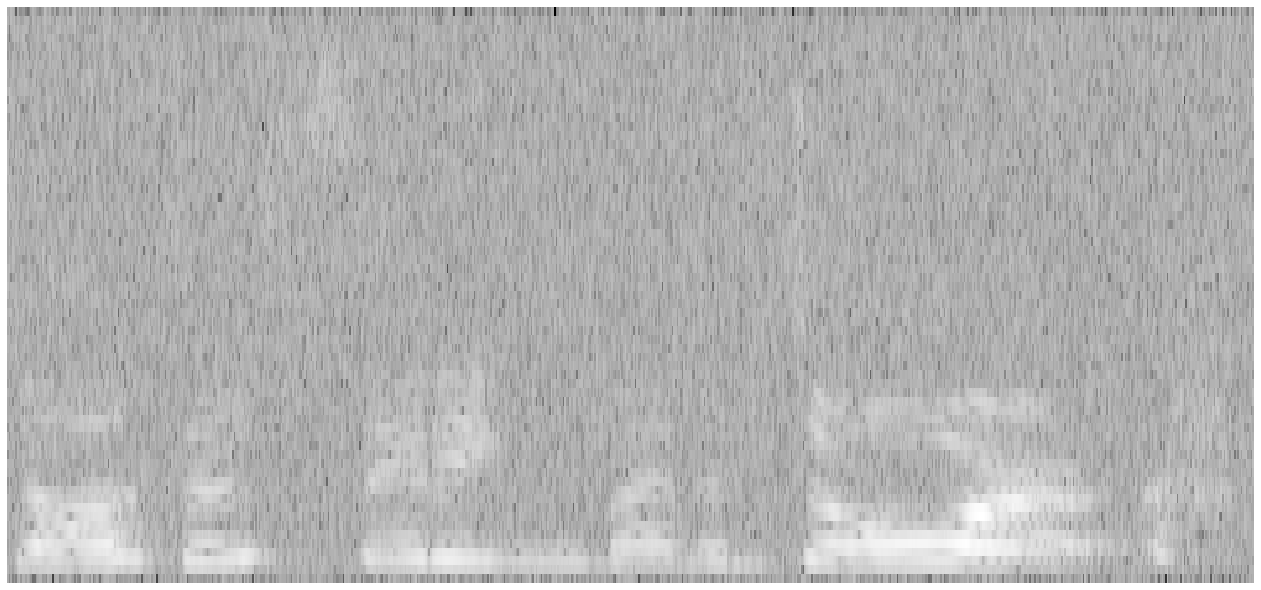

In [87]:
# STEP 3: Create spectograms
ravdess.create_spectograms() # might crash due to https://github.com/matplotlib/matplotlib/issues/8519

RAVDESS/spectograms/03-01-06-02-02-02-07-02.png


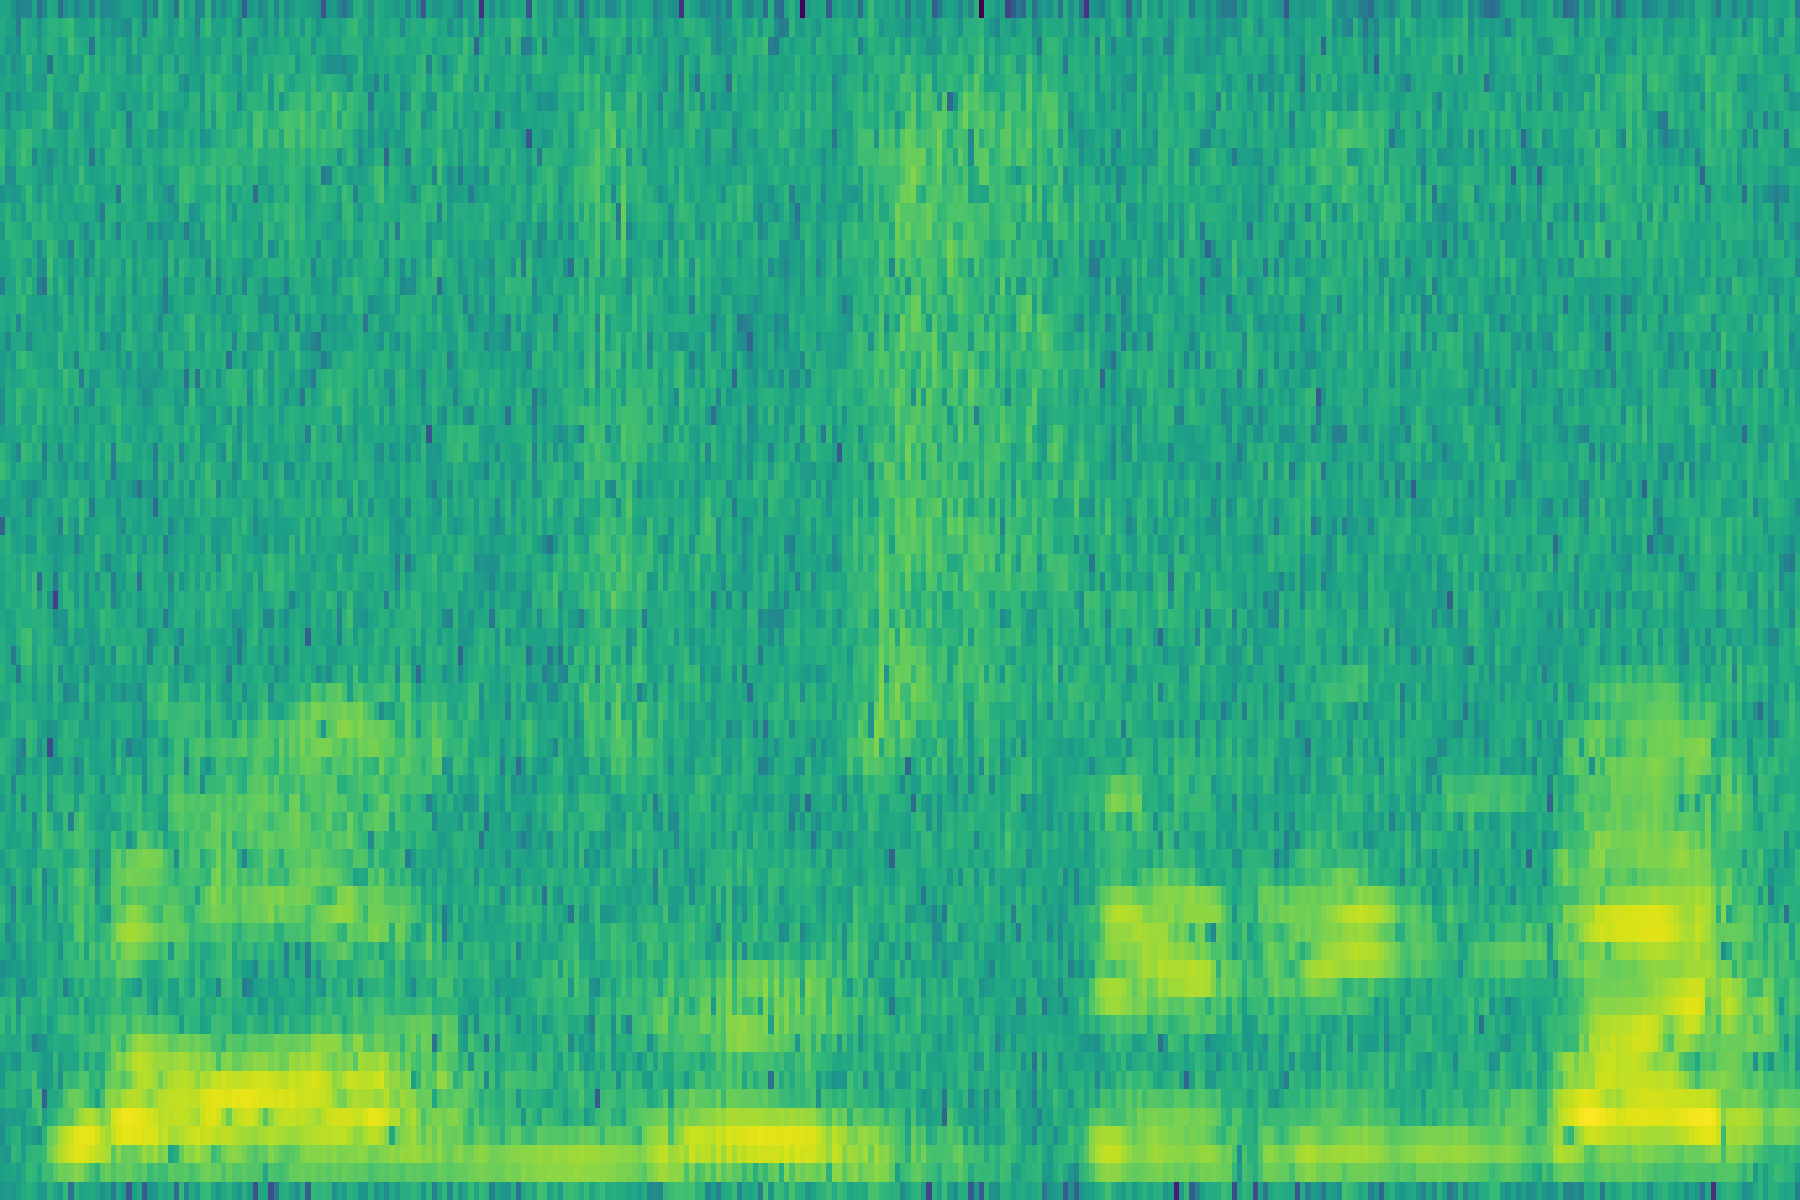

RAVDESS/spectograms/03-01-04-01-02-01-22-01.png


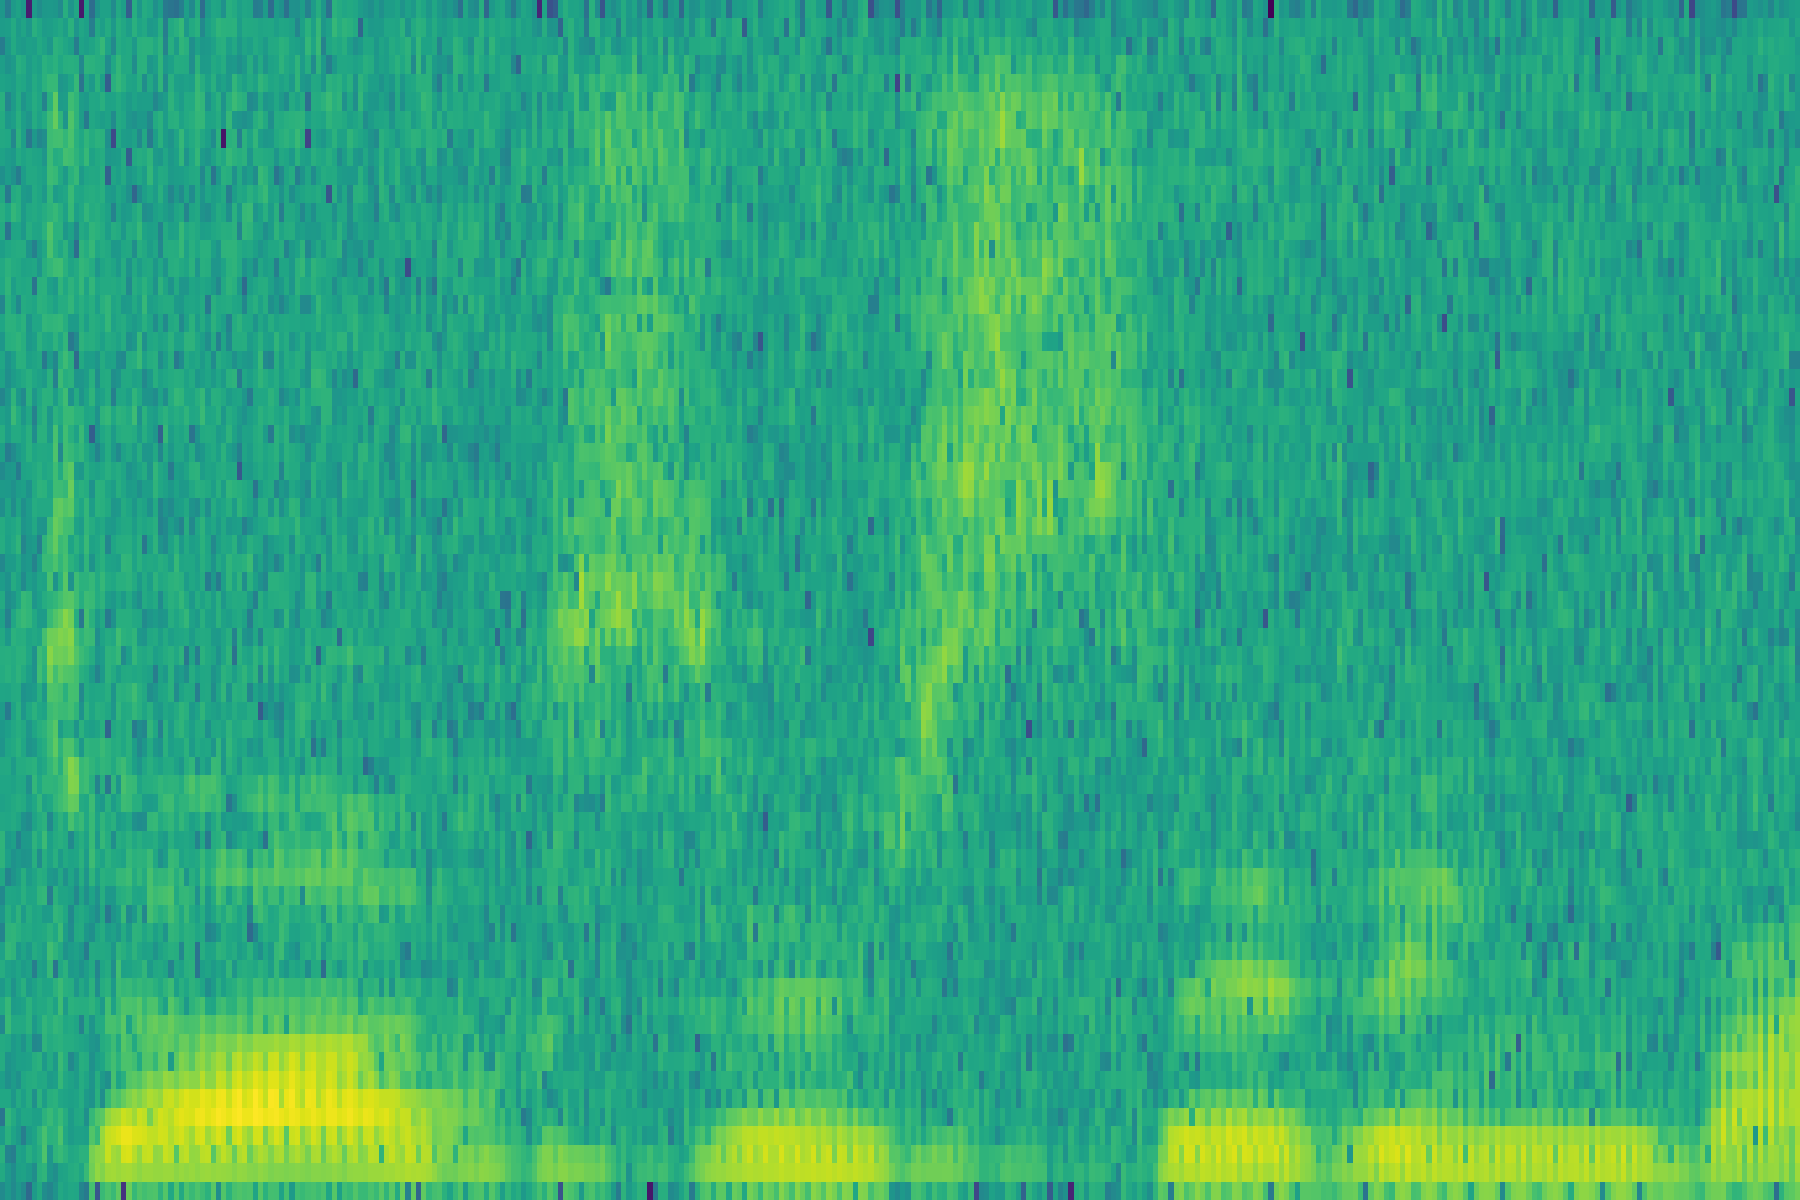

RAVDESS/spectograms/03-01-01-01-01-01-15-02.png


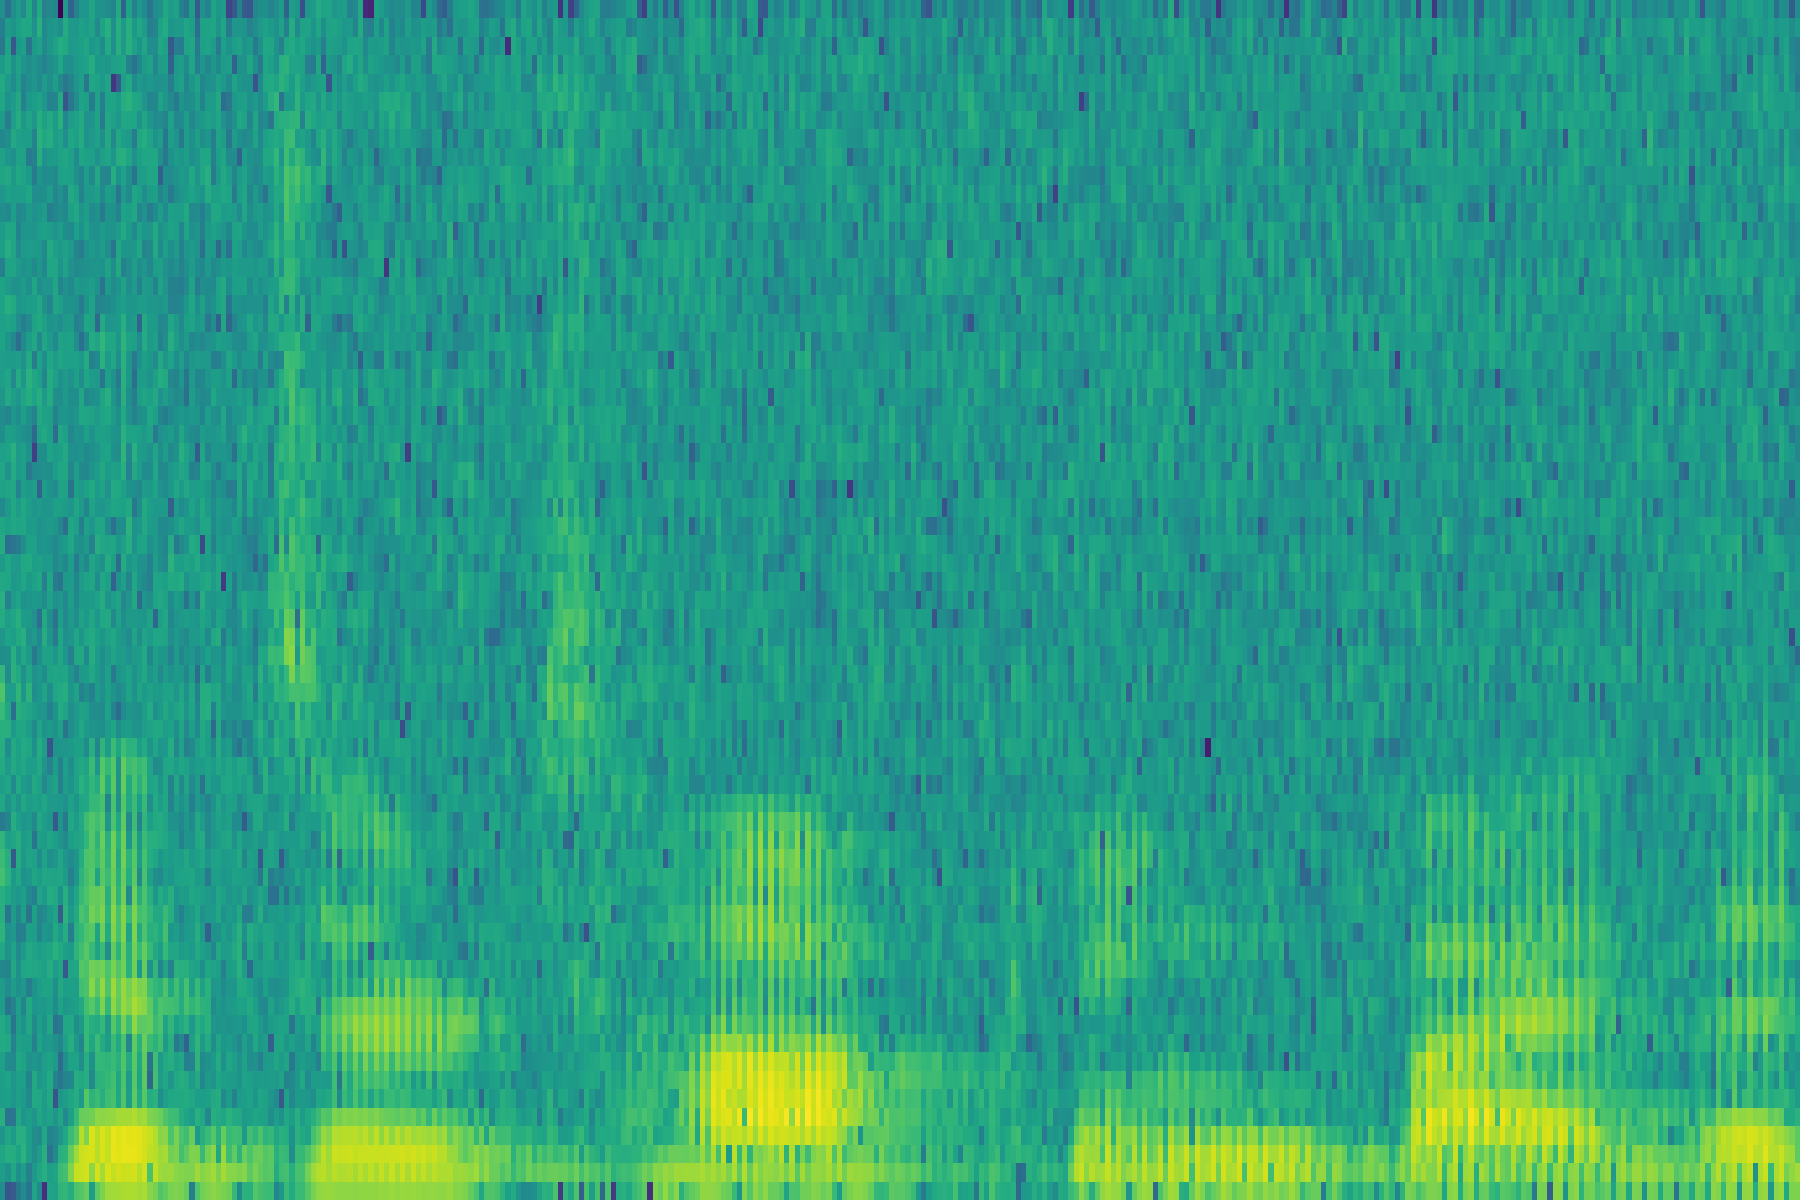

RAVDESS/spectograms/03-01-03-01-02-02-09-01.png


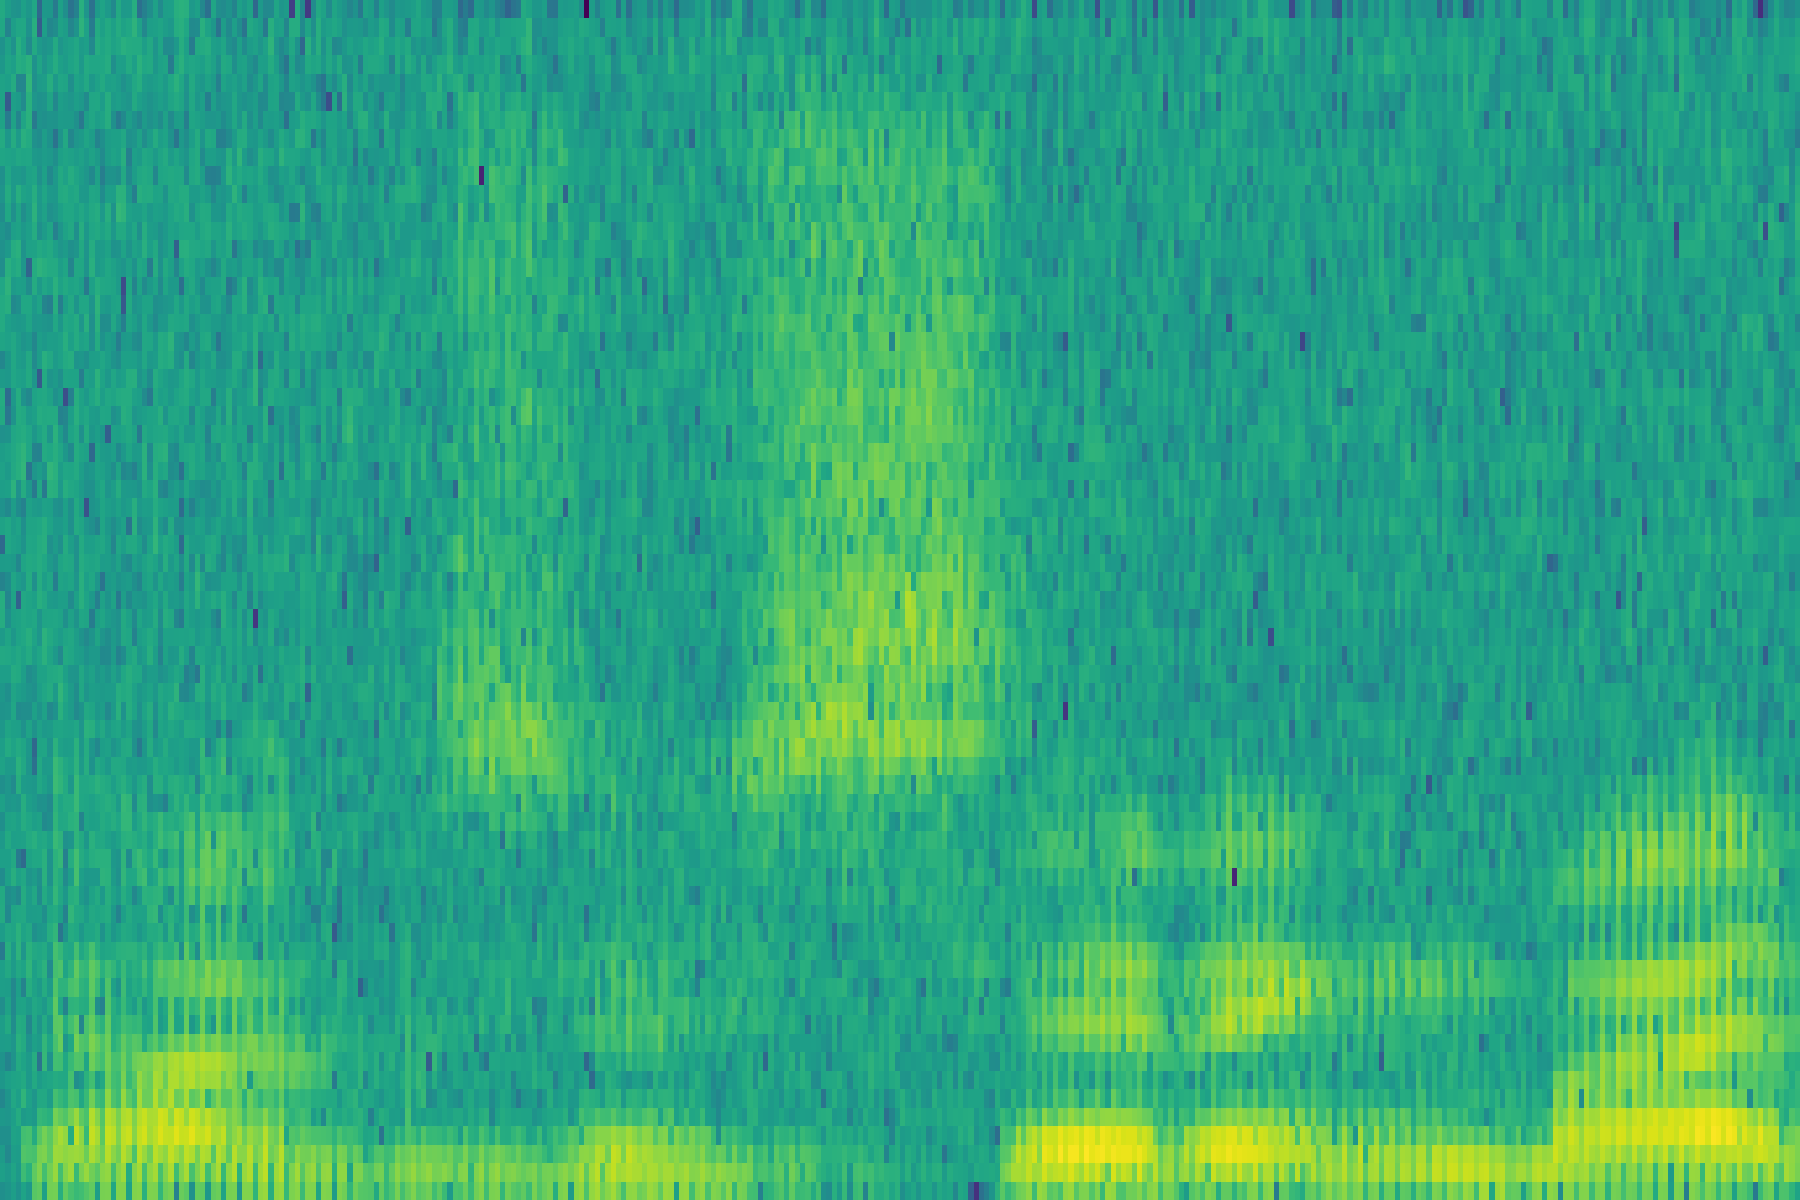

RAVDESS/spectograms/03-01-04-01-02-02-07-02.png


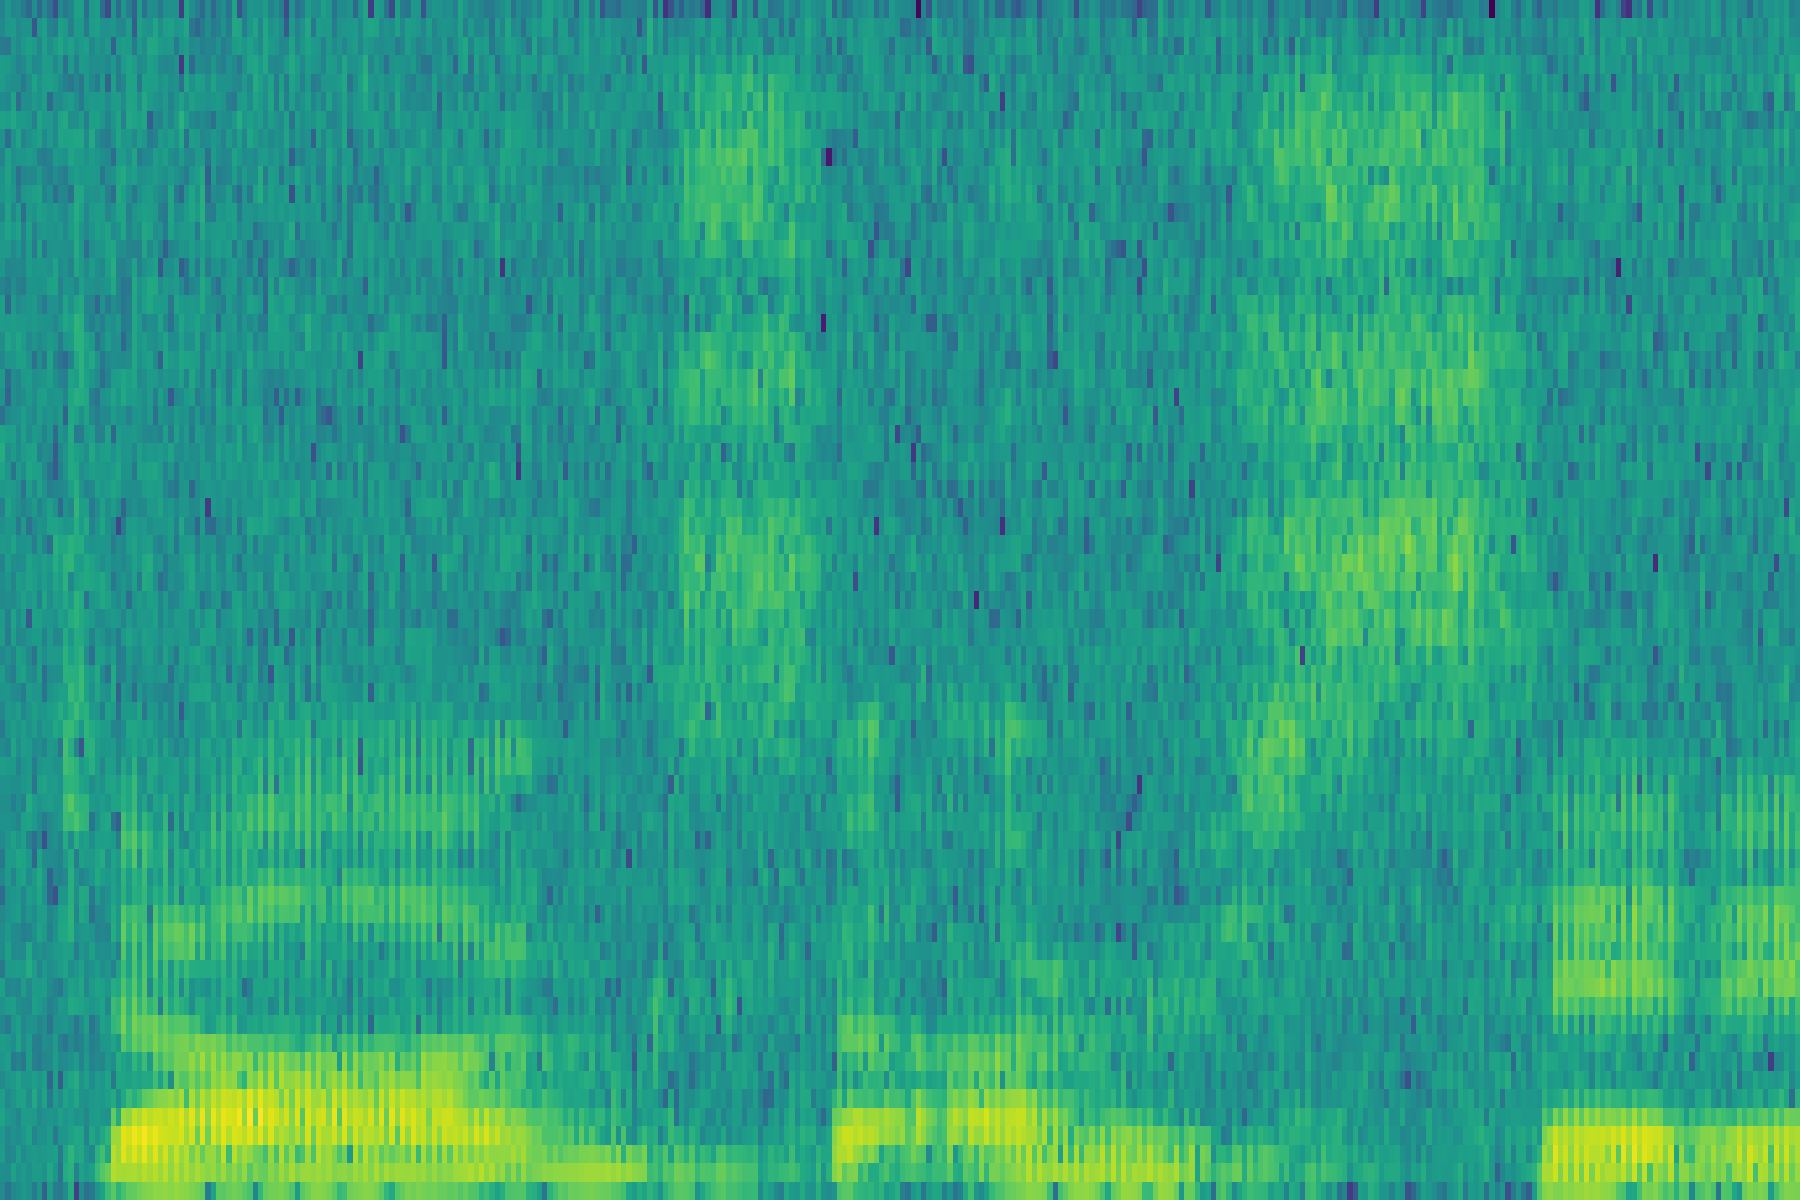

RAVDESS/spectograms/03-01-07-01-02-02-16-02.png


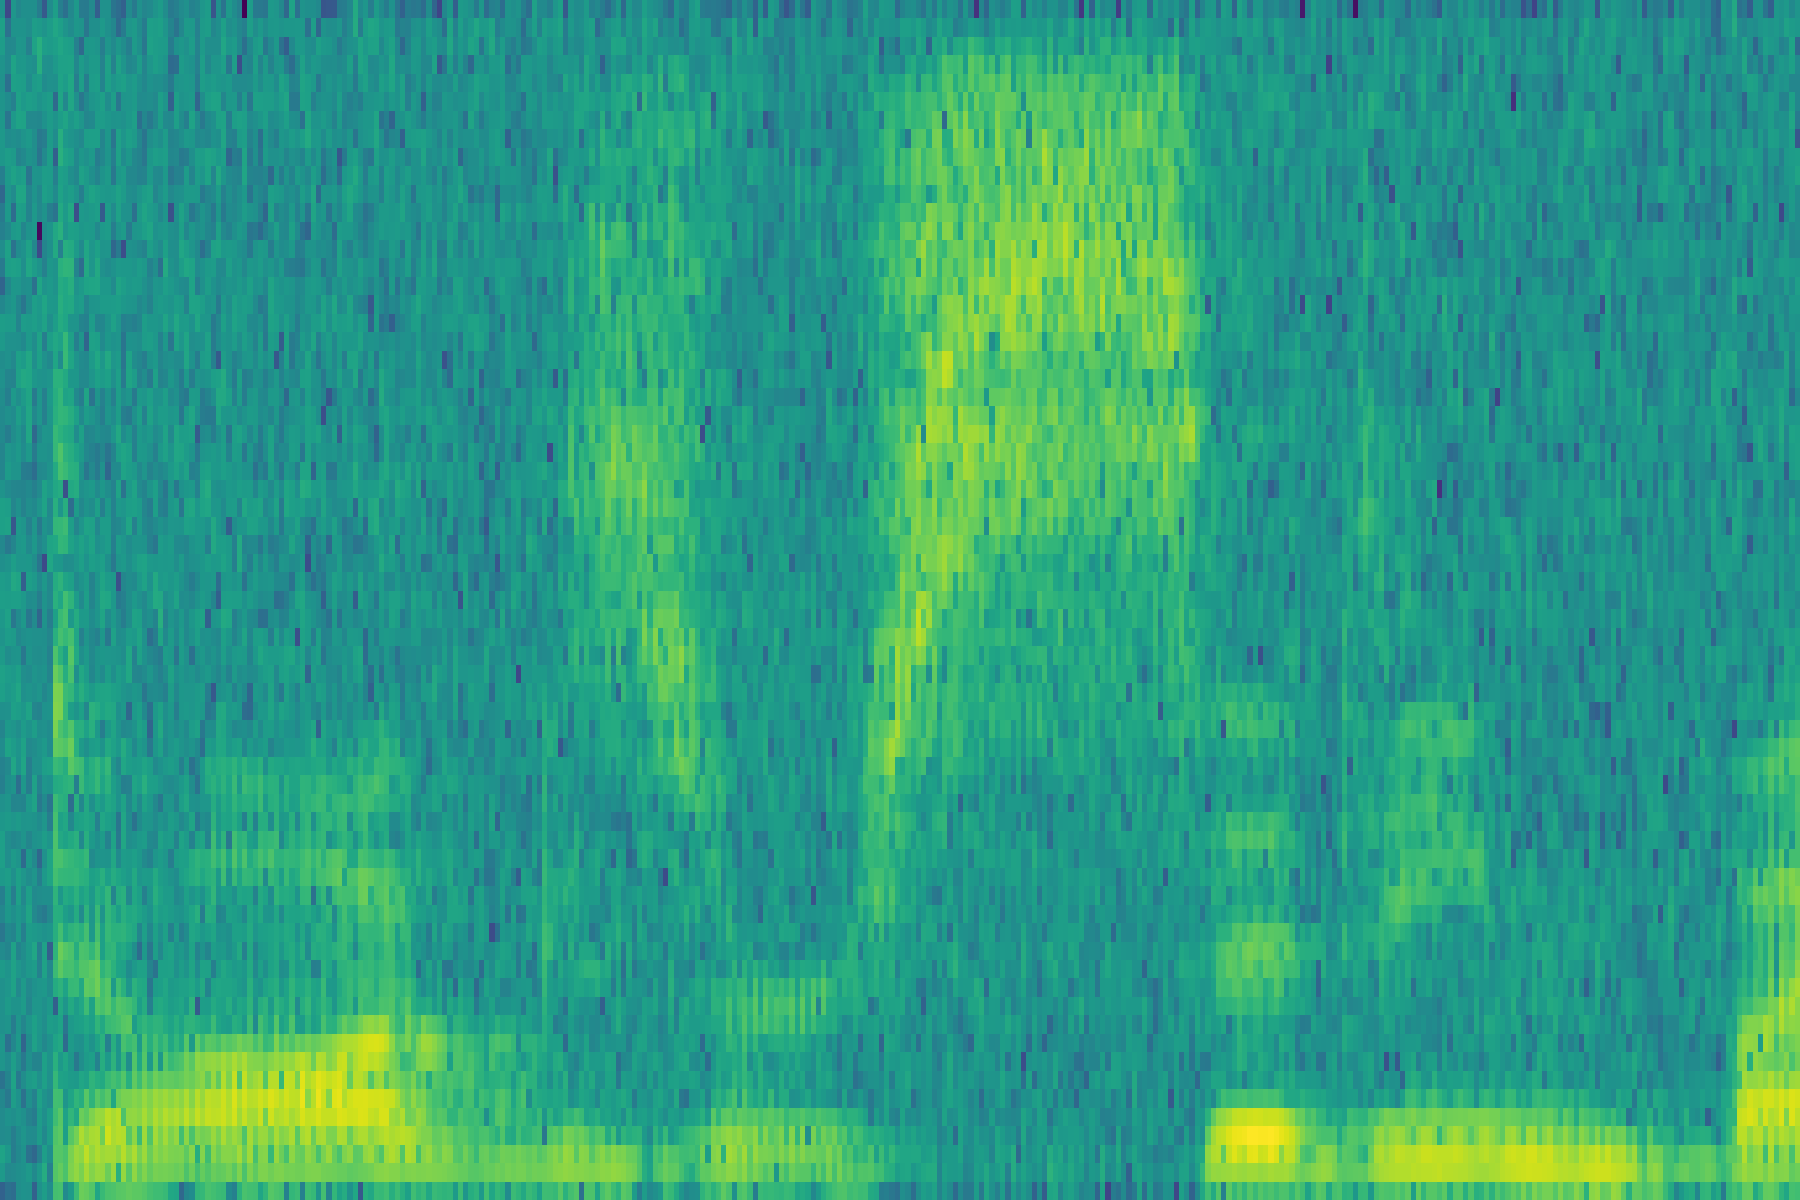

RAVDESS/spectograms/03-01-02-02-01-01-19-00.png


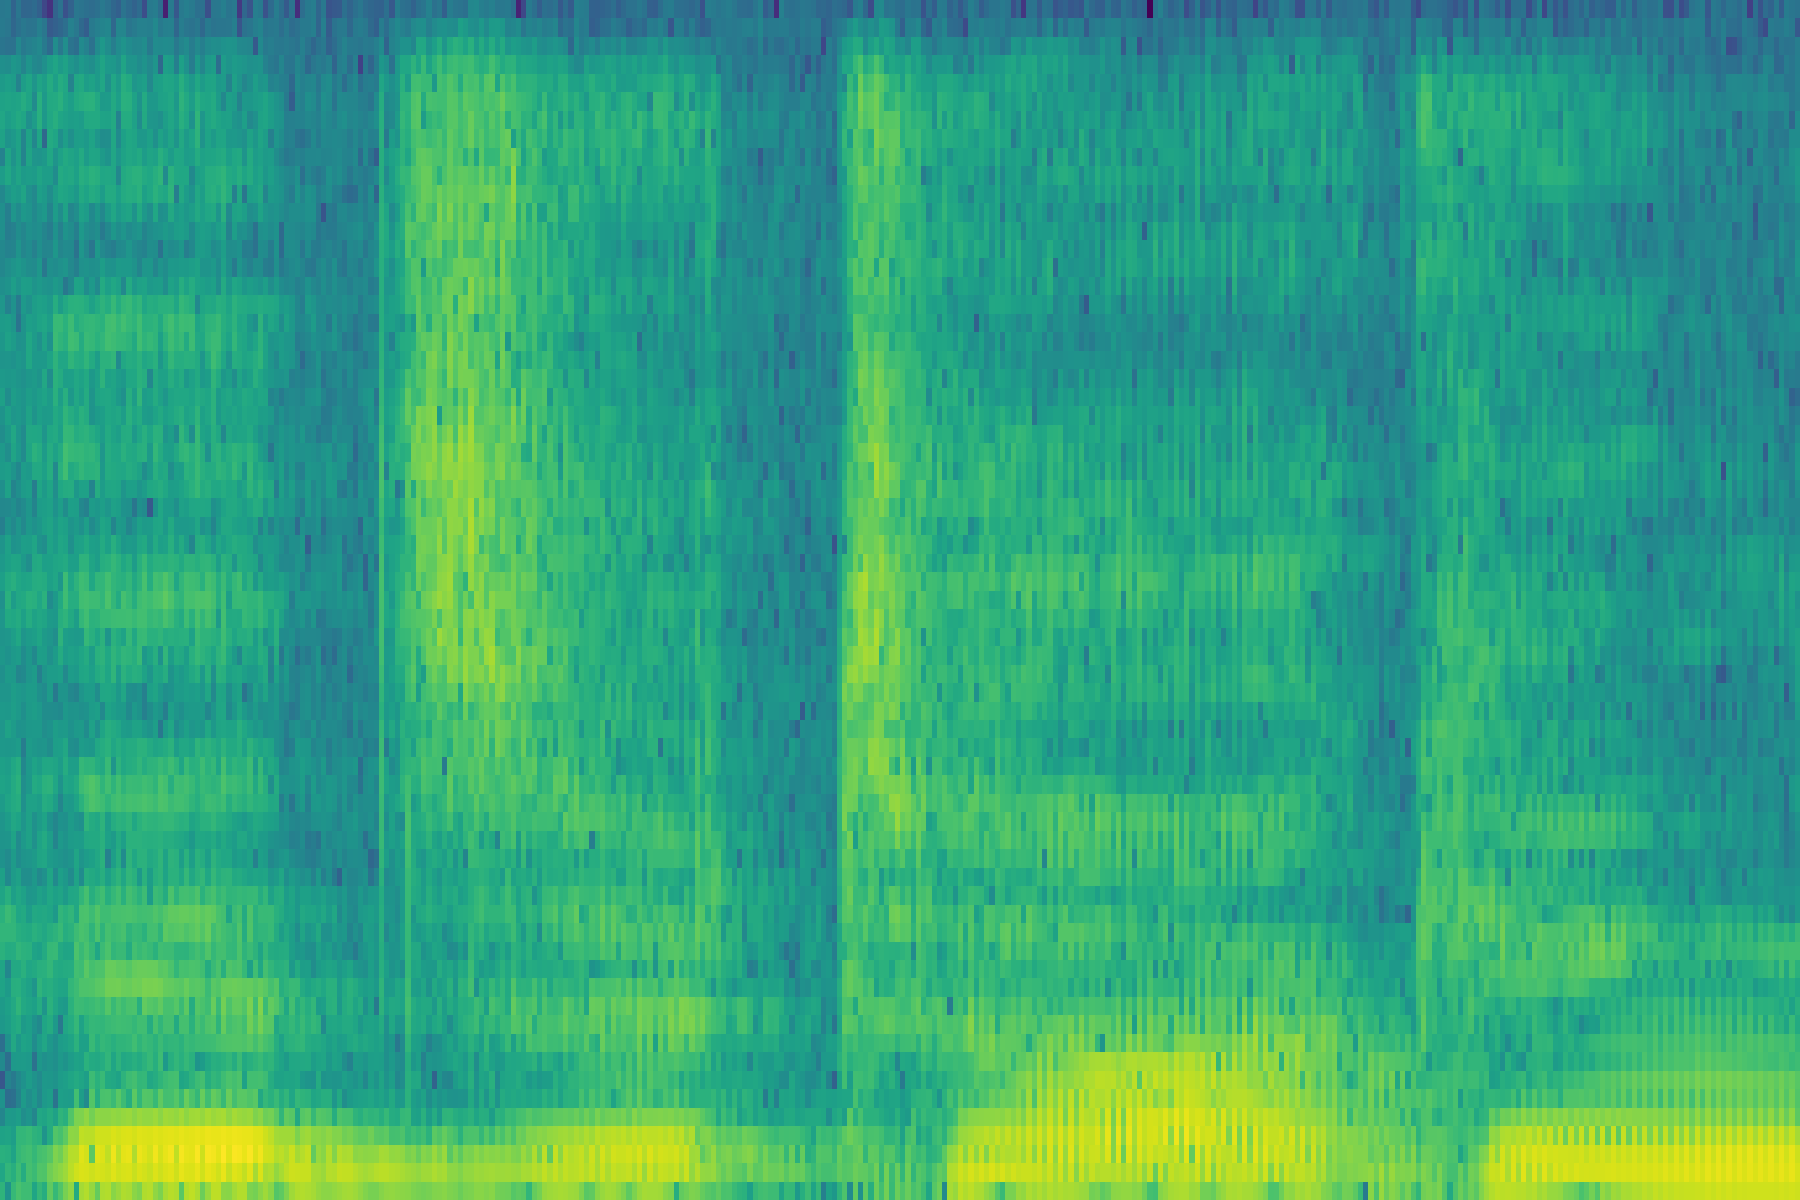

RAVDESS/spectograms/03-01-04-02-01-02-05-00.png


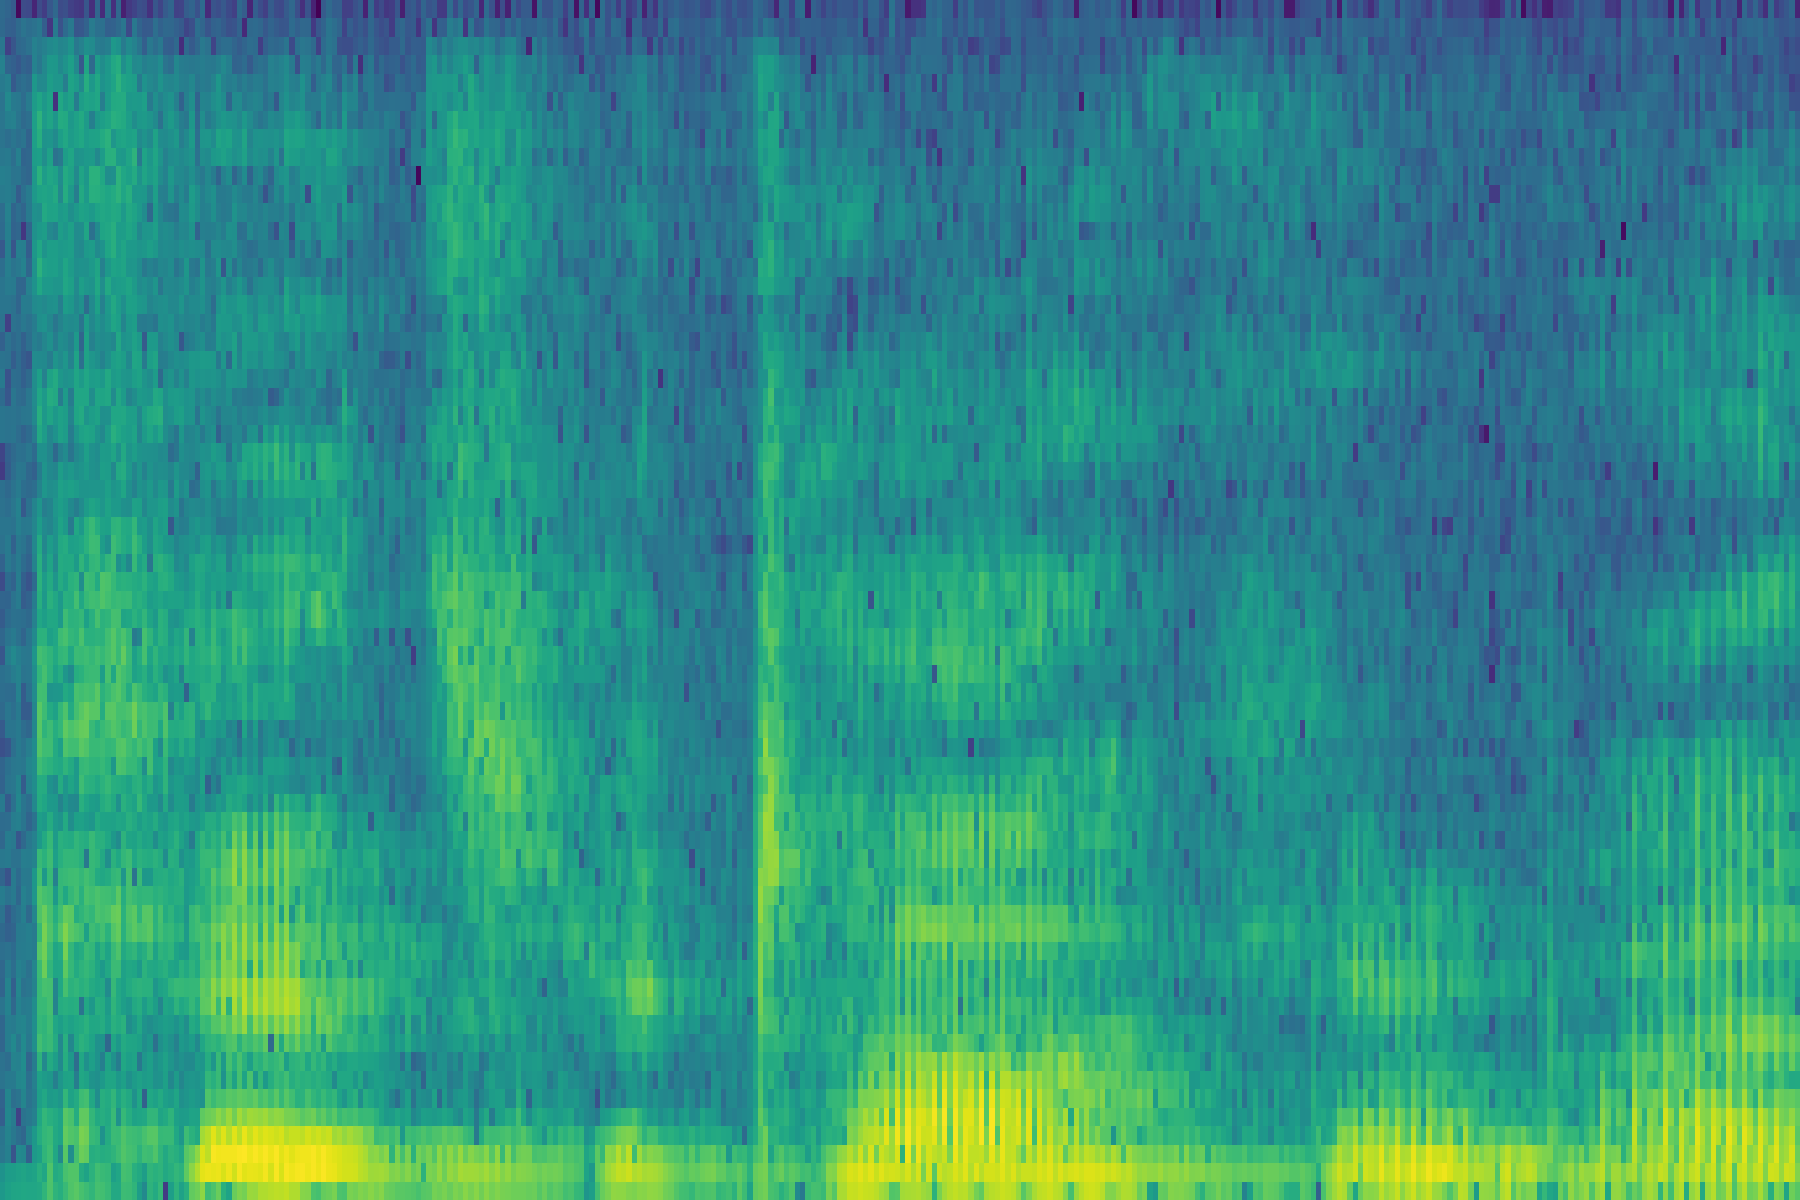

RAVDESS/spectograms/03-01-05-02-02-02-22-01.png


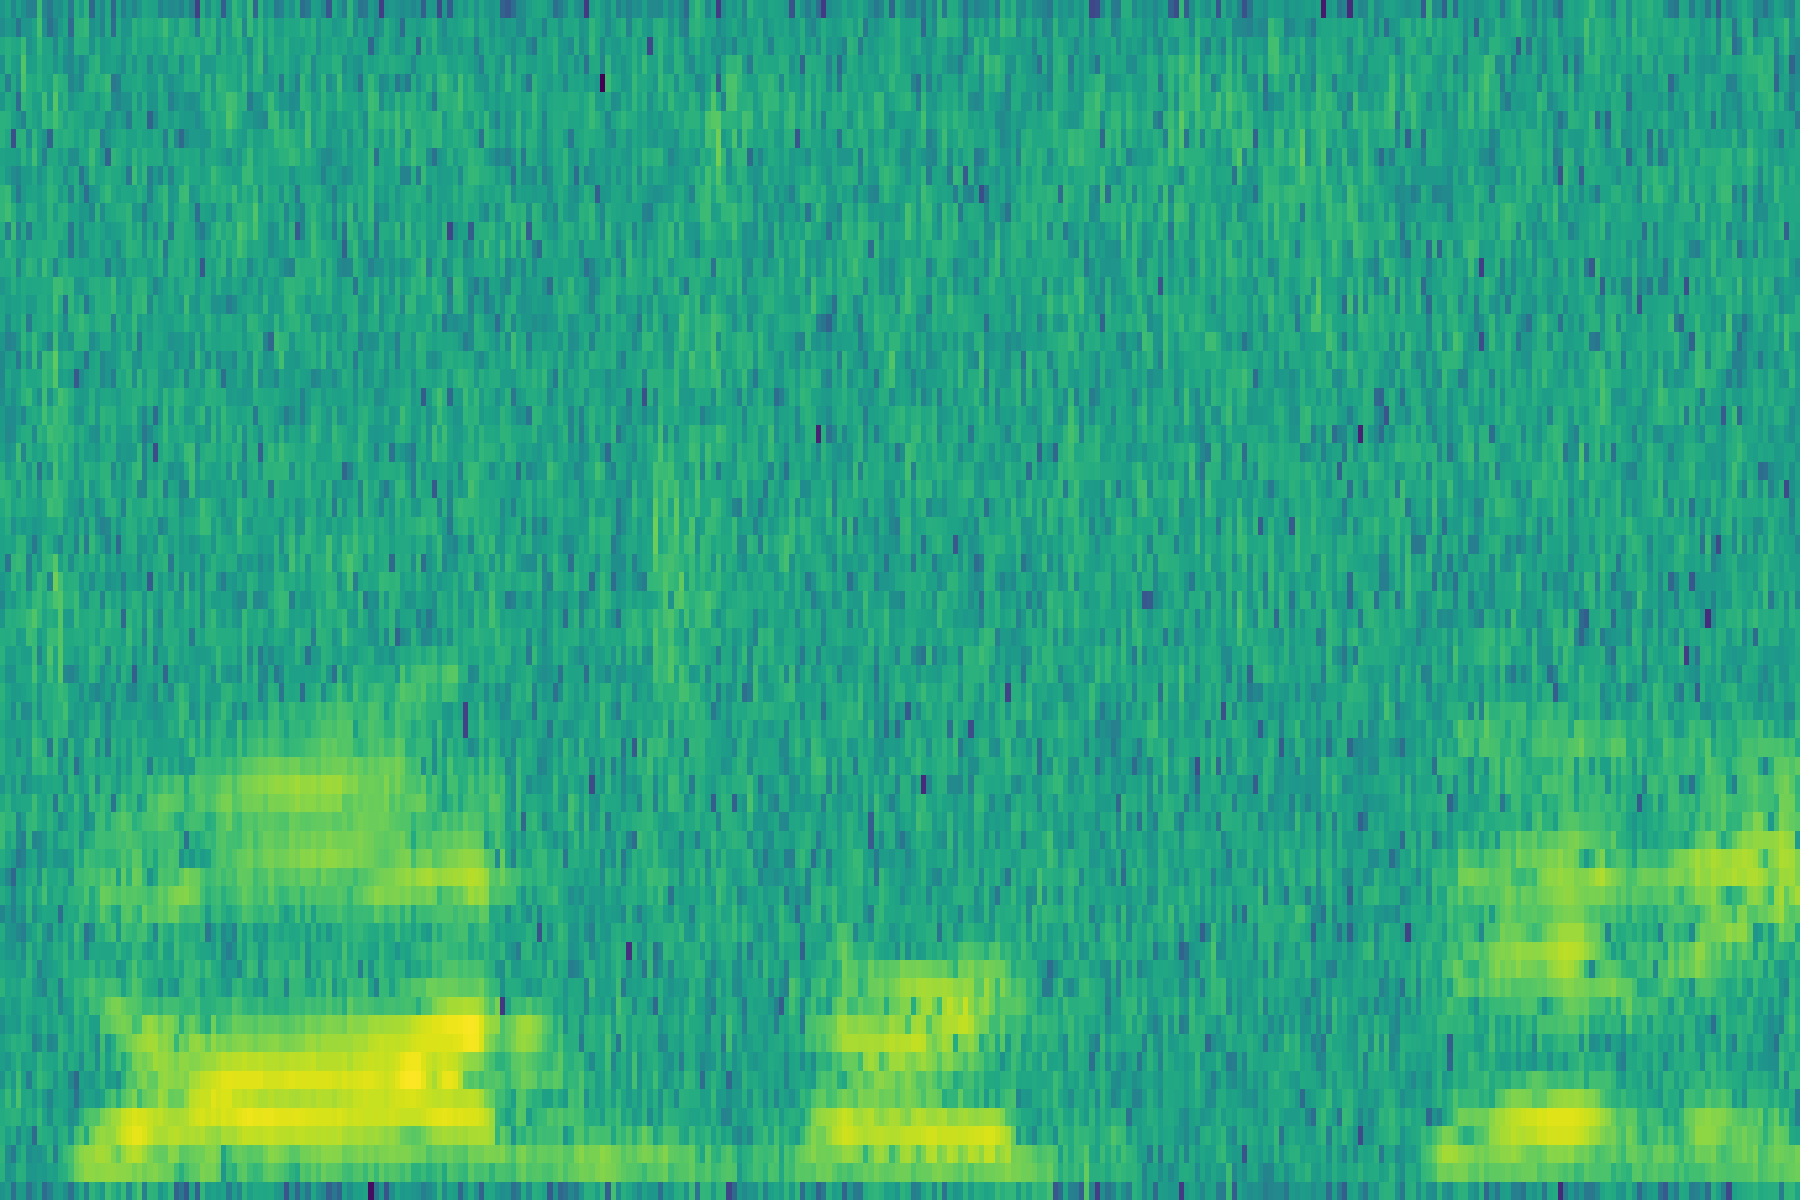

RAVDESS/spectograms/03-01-05-01-01-02-24-00.png


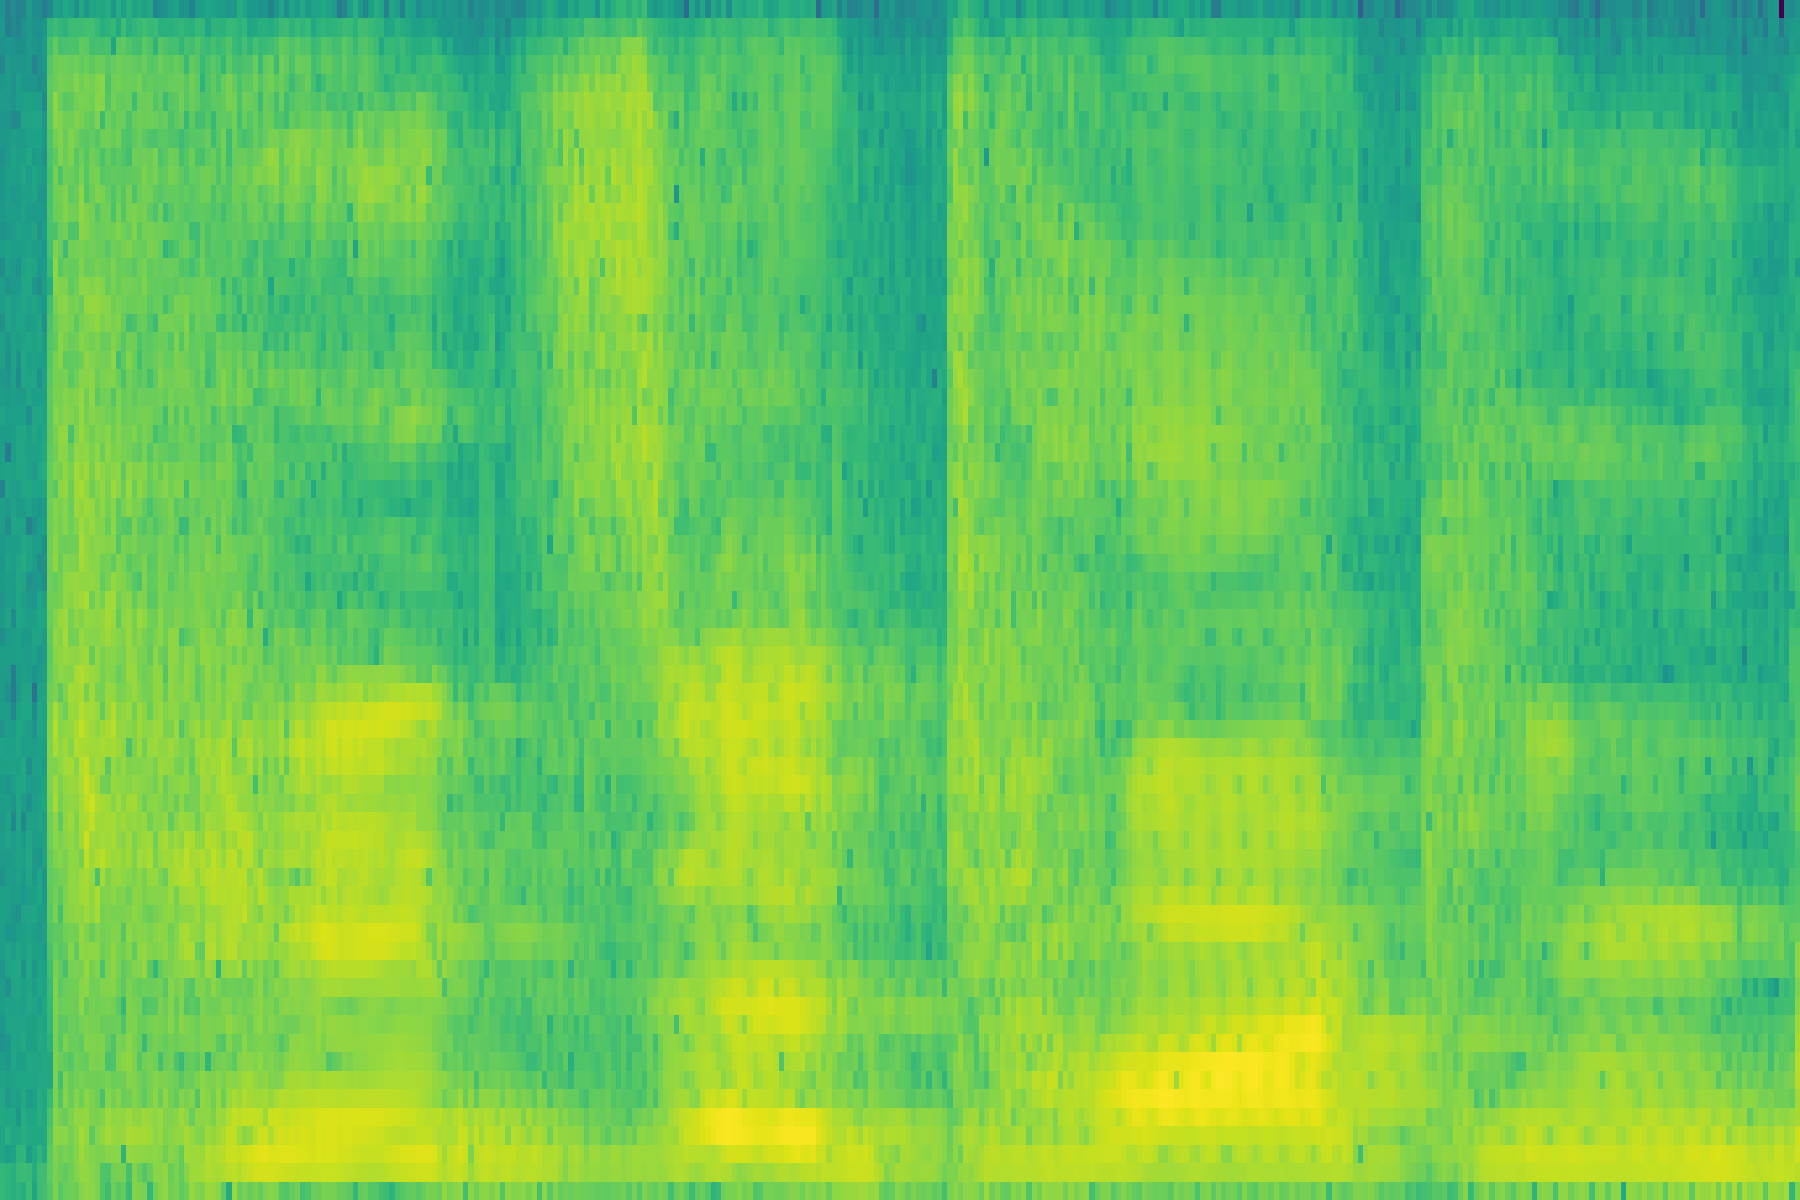

In [0]:
# Display spectograms

for i in range(10):
  spectograms = ravdess.get_spectograms_paths()
  random_spec =  random.choice(spectograms)
  print(random_spec)
  display(Image(random_spec, width=360, height=240))

In [0]:
# STEP 4: Create dataframe
df = ravdess.create_dataframe()
df.head()

Create dataframe


,image,emotion_angry,emotion_calm,emotion_disgust,emotion_fearful,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised,emotion_intensity_normal,emotion_intensity_strong,statement_Dogs_are_sitting_by_the_door,statement_Kids_are_talking_by_the_door,repetition_01,repetition_02,actor_01,actor_02,actor_03,actor_04,actor_05,actor_06,actor_07,actor_08,actor_09,actor_10,actor_11,actor_12,actor_13,actor_14,actor_15,actor_16,actor_17,actor_18,actor_19,actor_20,actor_21,actor_22,actor_23,actor_24,actor_gender_female,actor_gender_male
0,RAVDESS/spectograms/03-01-08-02-01-02-05-00.png,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,RAVDESS/spectograms/03-01-03-02-02-01-19-00.png,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,RAVDESS/spectograms/03-01-02-01-02-01-15-00.png,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,RAVDESS/spectograms/03-01-08-01-01-02-05-02.png,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,RAVDESS/spectograms/03-01-05-02-02-01-01-02.png,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Export to Google Drive

This part is optional. It is used to export the modified Data Set to your Google Drive.

In [0]:
!zip -r RAVDESS_spectogram.zip RAVDESS

In [0]:
!ls -l

In [0]:
# Export the data to your drive

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# zip name must match the name given to zip
zip_name = 'RAVDESS_spectogram.zip'

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': zip_name})
uploaded.SetContentFile(zip_name)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [58]:
audio_paths = ravdess.get_enriched_audio_paths()
audio_paths

['RAVDESS/enriched/03-01-04-02-01-01-15-01.wav',
 'RAVDESS/enriched/03-01-02-01-01-02-13-01.wav',
 'RAVDESS/enriched/03-01-05-02-02-02-08-01.wav',
 'RAVDESS/enriched/03-01-03-01-01-02-19-00.wav',
 'RAVDESS/enriched/03-01-04-01-01-01-10-01.wav',
 'RAVDESS/enriched/03-01-06-01-02-02-15-02.wav',
 'RAVDESS/enriched/03-01-01-01-02-01-15-00.wav',
 'RAVDESS/enriched/03-01-08-02-02-02-05-01.wav',
 'RAVDESS/enriched/03-01-07-01-01-02-17-01.wav',
 'RAVDESS/enriched/03-01-05-02-02-01-23-00.wav',
 'RAVDESS/enriched/03-01-02-02-02-02-24-00.wav',
 'RAVDESS/enriched/03-01-08-01-02-01-07-00.wav',
 'RAVDESS/enriched/03-01-08-02-02-02-21-01.wav',
 'RAVDESS/enriched/03-01-05-01-02-02-19-01.wav',
 'RAVDESS/enriched/03-01-06-01-02-01-14-02.wav',
 'RAVDESS/enriched/03-01-01-01-01-02-16-01.wav',
 'RAVDESS/enriched/03-01-07-02-02-01-11-02.wav',
 'RAVDESS/enriched/03-01-02-02-02-02-04-01.wav',
 'RAVDESS/enriched/03-01-08-02-02-01-01-01.wav',
 'RAVDESS/enriched/03-01-02-01-02-02-01-00.wav',
 'RAVDESS/enriched/0

In [37]:
audio_data, samplerate = sf.read(audio_path)
len(audio_data)

30208

In [0]:
window_lenght = samplerate * 1
window_offset = math.floor(samplerate * 0.1)
window_start = 0
split_audio_data = audio_data[window_start : window_start + window_lenght]
nfft = 128

In [39]:
len(split_audio_data)

22000

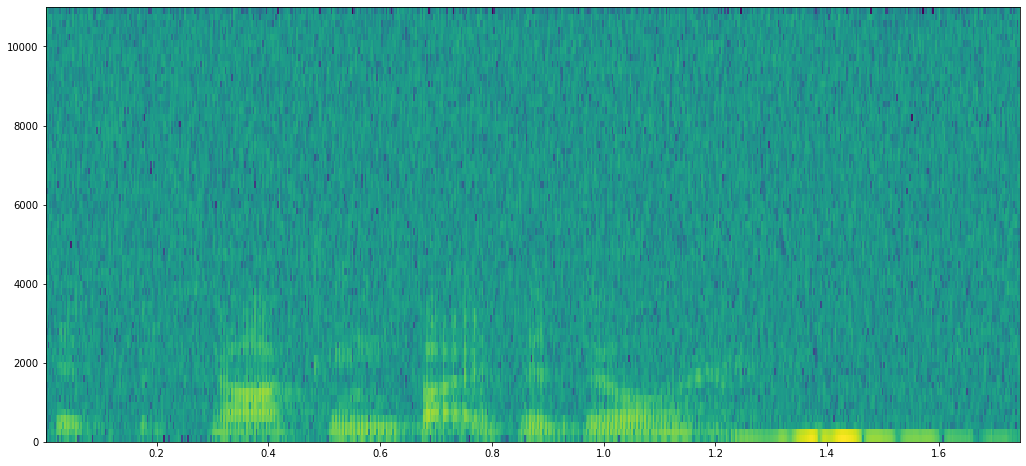

In [61]:
audio_data, samplerate = sf.read(audio_paths[0])
fig,ax = plt.subplots(1)
fig.set_size_inches(len(audio_data)*10/samplerate,8)
spect, f, t, image = plt.specgram(audio_data, NFFT=nfft, Fs=samplerate, noverlap=nfft/2)

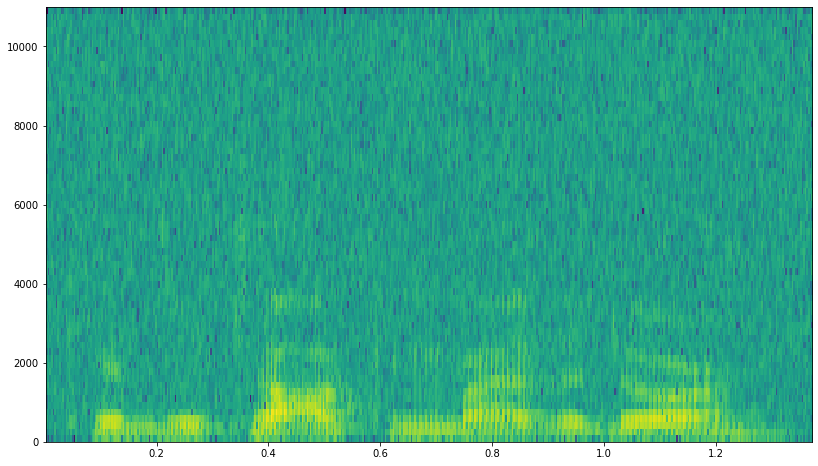

In [62]:
audio_data, samplerate = sf.read(audio_paths[1])
fig,ax = plt.subplots(1)
fig.set_size_inches(len(audio_data)*10/samplerate,8)
spect, f, t, image = plt.specgram(audio_data, NFFT=nfft, Fs=samplerate, noverlap=nfft/2)

In [54]:

len(audio_data)/samplerate

1.3730909090909091

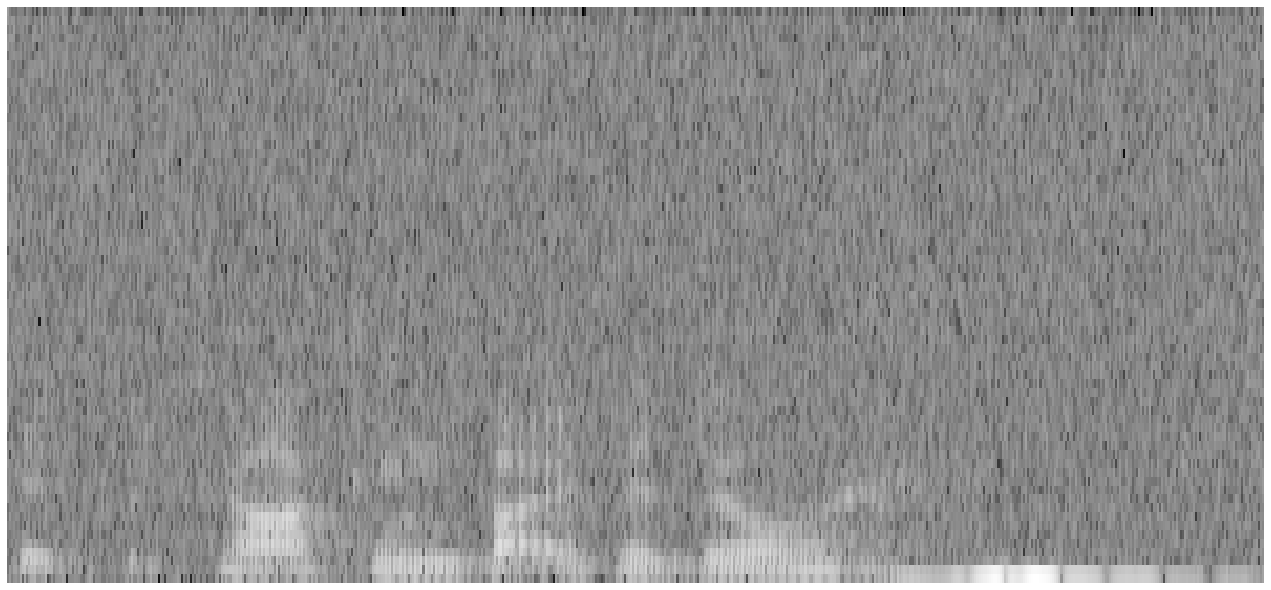

In [74]:
fig,ax = plt.subplots(1)
audio_data, samplerate = sf.read(audio_paths[0])
nfft = 128
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
fig.set_size_inches(len(audio_data)*10/samplerate,8)
spect, f, t, image = plt.specgram(audio_data, NFFT=nfft, Fs=samplerate, noverlap=nfft/2)
plt.axis('off')
plt.gray() # convert the image into black-and-white
plt.savefig('test0.png', dpi=300)

10.984727272727273


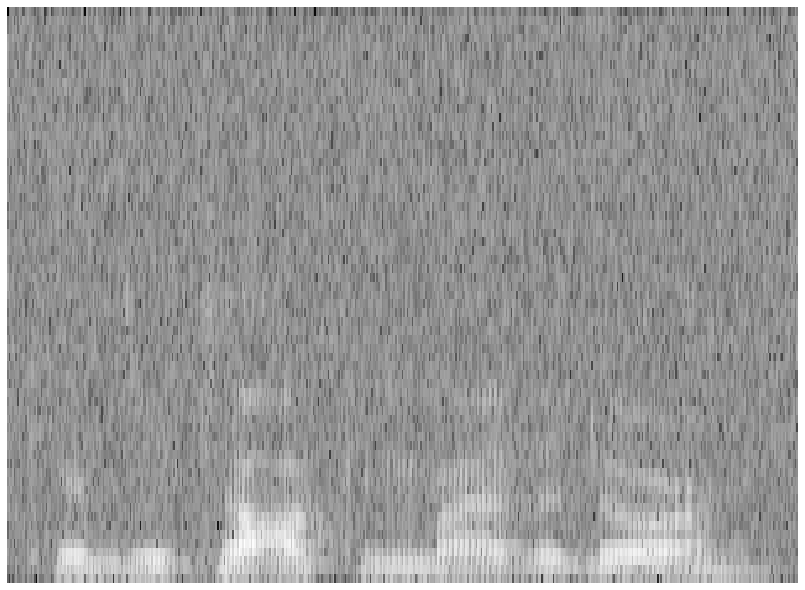

In [82]:
fig,ax = plt.subplots(1)
audio_data, samplerate = sf.read(audio_paths[1])
nfft = 128
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
fig.set_size_inches(8*len(audio_data)/samplerate,8)
spect, f, t, image = plt.specgram(audio_data, NFFT=nfft, Fs=samplerate, noverlap=nfft/2)
plt.axis('off')
plt.gray() # convert the image into black-and-white
plt.savefig('test1.png', dpi=300)